In [1]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2


In [39]:
import easydict
args = easydict.EasyDict({ "-i": '11.jpg', "-east": 'frozen_east_text_detection.pb'})


In [40]:
# load the input image and grab the image dimensions
image = cv2.imread(args["-i"])
orig = image.copy()
(H, W) = image.shape[:2]
 
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [12]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

In [14]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["-east"])
 
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
 
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.327062 seconds


In [17]:

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
 
# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    
    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

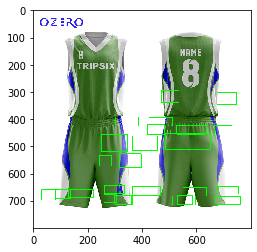

In [41]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
 
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)


import matplotlib.pyplot as plt
# show the output image
plt.imshow(orig)

### Implementation w/ customization

In [28]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Conv2D, concatenate, BatchNormalization, Lambda, Input, multiply, add, ZeroPadding2D, Activation, Layer, MaxPooling2D, Dropout
from keras import regularizers
import keras.backend as K
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [30]:
resnet = ResNet50(weights='imagenet', include_top=False, pooling=None)
resnet.summary()

D:\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [31]:
RESIZE_FACTOR = 2

def resize_bilinear(x):
    return tf.image.resize_bilinear(x, size=[K.shape(x)[1]*RESIZE_FACTOR, K.shape(x)[2]*RESIZE_FACTOR])

def resize_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4
    shape[1] *= RESIZE_FACTOR
    shape[2] *= RESIZE_FACTOR
    return tuple(shape)

In [32]:
class EAST_model:

    def __init__(self, input_size=512):
        input_image = Input(shape=(None, None, 3), name='input_image')
        overly_small_text_region_training_mask = Input(shape=(None, None, 1), name='overly_small_text_region_training_mask')
        text_region_boundary_training_mask = Input(shape=(None, None, 1), name='text_region_boundary_training_mask')
        target_score_map = Input(shape=(None, None, 1), name='target_score_map')
        resnet = ResNet50(input_tensor=input_image, weights='imagenet', include_top=False, pooling=None)
        x = resnet.get_layer('activation_49').output

        x = Lambda(resize_bilinear, name='resize_1')(x)
        x = concatenate([x, resnet.get_layer('activation_40').output], axis=3)
        x = Conv2D(128, (1, 1), padding='same', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
        x = Activation('relu')(x)
        x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
        x = Activation('relu')(x)

        x = Lambda(resize_bilinear, name='resize_2')(x)
        x = concatenate([x, resnet.get_layer('activation_22').output], axis=3)
        x = Conv2D(64, (1, 1), padding='same', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
        x = Activation('relu')(x)
        x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
        x = Activation('relu')(x)

        x = Lambda(resize_bilinear, name='resize_3')(x)
        x = concatenate([x, ZeroPadding2D(((1, 0),(1, 0)))(resnet.get_layer('activation_10').output)], axis=3)
        x = Conv2D(32, (1, 1), padding='same', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
        x = Activation('relu')(x)
        x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
        x = Activation('relu')(x)

        x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
        x = Activation('relu')(x)

        pred_score_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='pred_score_map')(x)
        rbox_geo_map = Conv2D(4, (1, 1), activation=tf.nn.sigmoid, name='rbox_geo_map')(x) 
        rbox_geo_map = Lambda(lambda x: x * input_size)(rbox_geo_map)
        angle_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='rbox_angle_map')(x)
        angle_map = Lambda(lambda x: (x - 0.5) * np.pi / 2)(angle_map)
        pred_geo_map = concatenate([rbox_geo_map, angle_map], axis=3, name='pred_geo_map')

        model = Model(inputs=[input_image, overly_small_text_region_training_mask, text_region_boundary_training_mask, target_score_map], outputs=[pred_score_map, pred_geo_map])

        self.model = model
        self.input_image = input_image
        self.overly_small_text_region_training_mask = overly_small_text_region_training_mask
        self.text_region_boundary_training_mask = text_region_boundary_training_mask
        self.target_score_map = target_score_map
        self.pred_score_map = pred_score_map
        self.pred_geo_map = pred_geo_map

In [35]:
from keras.optimizers import Optimizer
from keras.legacy import interfaces

class AdamW(Optimizer):
    """Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Decoupled weight decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/index.html)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4,  # decoupled weight decay (1/4)
                 epsilon=1e-8, decay=0., **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (2/4)
        self.epsilon = epsilon
        self.initial_decay = decay

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd # decoupled weight decay (3/4)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - lr * wd * p # decoupled weight decay (4/4)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))